# Phantom Supply Chain Example

This notebook will walk you through the steps of designing and running a simple Phantom
experiment. It is based on the included ``supply-chain-1.py`` example that can be found
in the ``envs`` directory in the Phantom repo.

In this notebook we will construct the following elements:

- Actors & Agents
- Policies
- Reward Functions
- Environment

## Experiment Goals

We want to model a very simple supply chain consisting of three types of agents:
factories, shops and customers. Our supply chain has one product that is available in
whole units. We do not concern ourselves with prices or profits here.

<p align="center">
  <img src="img/supply-chain.svg" />
</p>

### Factory Actor

The factory is an actor in the experiment. This is because, unlike customers or the
shop, the factory does not need to take any actions - it is purely reactive.

The shop can make unlimitec requests for stock to the factory. The factory holds
unlimited stock and can dispatch unlimited stock to the shop if requested.

<p align="center">
  <img src="img/supply-chain-factory.svg" />
</p>

### Customer Agent

Customers are non-learning agents. Every step they make an order to the shop for a
variable quantity of products. We model the number of products requested with a Poisson
random distribution. Customers receive products from the shop after making an order. We
do not need to do anything with this when received.

<p align="center">
  <img src="img/supply-chain-customer.svg" />
</p>

### Shop Agent

The shop is the only learning agent in this experiment. It can hold infinite stock and
can request infinite stock from the factory. It receives orders from customers and
tries to fulfil these orders as best it can.

The shop takes one action each step - the request for more stock that it sends to the
factory. The amount it requests is decided by the policy. The policy is informed by
one observation: the amount of stock currently held by the shop.

The goal is for the shop to learn a policy where it makes the right amount of stock
requests to the factory so it can fulfil all it's orders without holding onto too much
unecessary stock. This goal is implemented in the shop agent's reward function.

<p align="center">
  <img src="img/supply-chain-shop.svg" />
</p>

## Implementation

First we import the libraries we require and define some constants:

In [ ]:
import gym
import matplotlib.pyplot as plt
import mercury as me
import numpy as np
import phantom as ph

NUM_EPISODE_STEPS = 100

NUM_CUSTOMERS = 5
SHOP_MAX_STOCK = 1000
SHOP_MAX_STOCK_REQUEST = 100

Phantom uses the ``Mercury`` library for handling the network of agents and actors and
the message passing between them and `Ray + RLlib <https://docs.ray.io/en/master/index.html>`_
for running and scaling the RL training.

As this experiment is simple we can easily define it entirely within one file. For more
complex, larger experiments it is recommended to split the code into multiple files,
making use of the modularity of Phantom.

Next, for each of our agent/actor types we define a new Python class that encapsulates
all the functionality the given agent/actor needs.

### Factory Actor

The Factory is the simplest to implement as it does not take actions and does not
store state. We inherit from Mercury's ``SimpleSyncActor`` class. The ``SimpleSyncActor``
is an actor that handles the message it receives in a synchronous order.

The ``SimpleSyncActor`` class requires that we implement a ``handle_message`` method in
our sub-class. Here we take any stock request we receive from the shop (the ``payload``
of the message) and reflect it back to the shop as the factory will always fulfils
stock requests.`


In [ ]:
class FactoryActor(me.actors.SimpleSyncActor):
    def __init__(self, actor_id: str):
        super().__init__(actor_id)

    # The 'handle_message' method must return messages as an iterator and hence we use
    # the 'yield' statement instead of the usual 'return' statement.
    def handle_message(self, ctx: me.Network.Context, msg: me.Message):
        # The factory receives stock request messages from shop agents. We
        # simply reflect the amount of stock requested back to the shop as the
        # factory has unlimited stock.
        yield (msg.sender_id, [msg.payload])

### Customer Agent

The implementation of the customer agent class takes more work as it stores state and
takes actions. For any agent to be able to interact with the RLlib framework we need to
define methods to decode actions, encode observations, compute reward functions. Our
customer agent takes actions according to a pre-defined policy - it does not actively
learn - and so we can use a ``FixedPolicy`` derived class to define this simple policy:

In [ ]:
class CustomerPolicy(ph.FixedPolicy):
    # The size of the order made for each customer is determined by this fixed policy.
    def compute_action(self, obs) -> int:
        return np.random.poisson(5)

Next we define the customer agent class. We make sure to set the policy to be our
custom fixed policy.

We define a custom ``decode_action`` method. This is called every step and allows the
customer agent to make orders to the shop. We use a random number generator to create
varying order sizes.

From this method we return a ``Packet`` object. This is a simple container than contains
``Mutators`` and ``Messages``. In this instance we are only filling it with messages --
mutators will be covered in a later tutorial.

The ``messages`` parameter of the ``Packet`` object is a mapping of recipient IDs to a
list of message payloads. This allows multiple messages to be send to a single
agent/actor. In our case we are sending a single message containing a numeric value
(the order size) to the shop.


In [ ]:
class CustomerAgent(ph.Agent):
    # We take the ID of the shop as an initialisation parameter and store it in the
    # agents local state. It is recommended to always handle IDs this way rather than 
    # hard-coding the values.
    def __init__(self, agent_id: str, shop_id: str):
        super().__init__(agent_id, policy_class=CustomerPolicy)

        # We need to store the shop's ID so we can send order requests to it.
        self.shop_id: str = shop_id

    def decode_action(self, ctx: me.Network.Context, action: np.ndarray):
        # At the start of each step we generate an order with a random size to
        # send to the shop.
        order_size = action

        # We perform this action by sending a stock request message to the factory.
        return ph.packet.Packet(messages={self.shop_id: [order_size]})

    # As before with the factory actor, we have to define a 'handle_message' method.
    # The customer receives messages from the shop containing the products the customer
    # requested. The customer does not need to take any action with these messages and
    # so we return an empty iterator using 'yield from ()'.
    def handle_message(self, ctx: me.Network.Context, msg: me.Message):
        # The customer will receive it's order from the shop but we do not need
        # to take any actions on it.
        yield from ()

    def compute_reward(self, ctx: me.Network.Context) -> float:
        # The customer agent does not learn so we do not need to construct a reward
        # function but we do need to still return a value to satisfy RLlib.
        return 0.0

    def encode_obs(self, ctx: me.Network.Context):
        # The customer agent does not observe anything from the environment but we
        # have to provide a value nonetheless.
        return 0

    def get_observation_space(self):
        return gym.spaces.Discrete(1)

    def get_action_space(self):
        return gym.spaces.Discrete(100)

### Shop Agent

As the learning agent in our experiment, the shop agent is the most complex and
introduces some new features of Phantom. As seen below, we store more local state than
before.

We keep track of sales and missed sales over two time spans: for each step (to guide the
policy) and for each episode (for logging purposes).

In [ ]:
class ShopAgent(ph.Agent):
    def __init__(self, agent_id: str, factory_id: str):
        super().__init__(agent_id)

        # We store the ID of the factory so we can send stock requests to it.
        self.factory_id: str = factory_id

         # We keep track of how much stock the shop has...
        self.stock: int = 0

        # ...and how many sales have been made...
        self.sales: int = 0

        # ...and how many sales per step the shop has missed due to not having enough
        # stock.
        self.missed_sales: int = 0

    # We want to keep track of how many sales and missed sales we made in the step. When
    # messages are sent, the shop will start taking orders. So before this happens we
    # want to reset our counters. We can do this by defining a 'pre_resolution' method.
    # This is called directly before messages are sent across the network in each step.
    def pre_resolution(self, ctx: me.Network.Context):
        # At the start of each step we reset the number of missed orders to 0.
        self.sales = 0
        self.missed_sales = 0

    # The handle_message method is logically split into two parts: handling messages
    # from the factory and handling messages from the customer.
    def handle_message(self, ctx: me.Network.Context, msg: me.Message):
        if msg.sender_id == self.factory_id:
            # Messages received from the factory contain stock.
            self.stock = min(self.stock + msg.payload, SHOP_MAX_STOCK)

            # We do not need to respond to these messages.
            yield from ()
        else:
            # All other messages are from customers and contain orders.
            amount_requested = msg.payload

            if amount_requested > self.stock:
                self.missed_sales += amount_requested - self.stock
                stock_to_sell = self.stock
                self.stock = 0
            else:
                stock_to_sell = amount_requested
                self.stock -= amount_requested

            self.sales += stock_to_sell

            # Send the customer their order.
            yield (msg.sender_id, [stock_to_sell])

    # The observation we send to the policy on each step is the shop's amount of stock
    # it currently holds. We allow this information to be sent by defining an
    # 'encode_obs' method:
    def encode_obs(self, ctx: me.Network.Context):
        # We encode the shop's current stock as the observation.
        return self.stock

    # We define a 'decode_action' method for taking the action from the policy and
    # translating it into messages to send in the environment. Here the action taken is
    # making requests to the factory for more stock. We place the messages we want to
    # send in a 'Packet' container.
    def decode_action(self, ctx: me.Network.Context, action: np.ndarray):
        # The action the shop takes is the amount of new stock to request from
        # the factory.
        stock_to_request = action

        # We perform this action by sending a stock request message to the factory.
        return ph.packet.Packet(messages={self.factory_id: [stock_to_request]})

    # Next we define a 'compute_reward' method. Every step we calculate a reward value
    # based on the agents current state in the environment and send it to the policy so
    # it can learn.
    def compute_reward(self, ctx: me.Network.Context) -> float:
        # We reward the agent for making sales.
        # We penalise the agent for holding onto stock and for missing orders.
        return self.sales - self.missed_sales - self.stock

    # Each episode can be thought of as a completely independent trial for the
    # environment. However creating a new environment each time with a new network,
    # actors and agents could potentially slow our simulations down a lot. Instead we
    # can reset our objects back to an initial state. This is done with the 'reset'
    # method:
    def reset(self):
        self.stock = 0

    # Finally we need to let RLlib know the sizes of our observation space and action
    # space so it can construct the correct neural network for the agent's policy. This
    # is done with the 'get_observation_space' and 'get_action_space' methods:
    def get_observation_space(self):
        return gym.spaces.Discrete(SHOP_MAX_STOCK + 1)

    def get_action_space(self):
        return gym.spaces.Discrete(SHOP_MAX_STOCK_REQUEST)

### Environment

Now we have defined all our actors and agents and their behaviours we can describe how
they will all interact by defining our environment. Phantom provides a base
``PhantomEnv`` class that the user should create their own class and inherit from. The
``PhantomEnv`` class provides a default set of required methods such as ``step`` which
coordinates the evolution of the environment for each episodes.

In [ ]:
class SupplyChainEnv(ph.PhantomEnv):
    env_name: str = "supply-chain-v1"

    def __init__(self, n_customers: int = 5):
        # Define actor and agent IDs
        shop_id = "SHOP"
        factory_id = "FACTORY"
        customer_ids = [f"CUST{i+1}" for i in range(n_customers)]

        # Define the agents and actors by creating instances of the classes:
        shop_agent = ShopAgent(shop_id, factory_id=factory_id)
        factory_actor = FactoryActor(factory_id)

        customer_agents = [CustomerAgent(cid, shop_id=shop_id) for cid in customer_ids]

        # Accumulate all our agents and actors in one list.
        actors = [shop_agent, factory_actor] + customer_agents

        # Define Network and create connections between Actors
        network = me.Network(me.resolvers.UnorderedResolver(), actors)

        # Connect the shop to the factory
        network.add_connection(shop_id, factory_id)

        # Connect the shop to the customers
        network.add_connections_between([shop_id], customer_ids)

        # Initialise the parent 'PhantomEnv' class, passing in the network, the number
        # of episode steps and an optional seed value:
        super().__init__(network=network, n_steps=NUM_EPISODE_STEPS)

## Metrics

Before we start training we add some basic metrics to help monitor the training progress.
These will be described in more detail in the second part of the tutorial.

In [ ]:
metrics = {}
metrics["SHOP/stock"] = ph.logging.SimpleAgentMetric("SHOP", "stock", "mean")
metrics["SHOP/sales"] = ph.logging.SimpleAgentMetric("SHOP", "sales", "mean")
metrics["SHOP/missed_sales"] = ph.logging.SimpleAgentMetric("SHOP", "missed_sales", "mean")


## Training the Shop Agent Policy

Training the agents is done by making use of one of RLlib's many reinforcement learning
algorithms. Phantom provides a wrapper around RLlib that hides much of the complexity.

Training in Phantom is initiated by calling the ``ph.train`` function, passing in the
parameters of the experiment. Any items given in the ``env_config`` dictionary will be
passed to the initialisation method of the environment.

In [ ]:
ph.train(
    experiment_name="supply-chain-notebook",
    algorithm="PPO",
    num_workers=8,
    num_episodes=5000,
    env_class=SupplyChainEnv,
    env_config=dict(n_customers=NUM_CUSTOMERS),
    metrics=metrics,
)

## Rollouts

Next we can test our trained policy in the simulation by performing rollouts:

In [ ]:
results = ph.rollout(
    directory="supply-chain-notebook/LATEST",
    algorithm="PPO",
    num_workers=0,
    num_repeats=100,
    env_config=dict(n_customers=NUM_CUSTOMERS),
    metrics=metrics,
    save_trajectories=True,
    save_messages=True,
)

## Post-Rollout Analysis

Here we show some basic examples of how the rollout episode data can be used to perform analysis on the behaviour of the environment and agents.

First we collect all the metrics and actions we are interested in across all steps in all rollouts:

In [ ]:
shop_actions = []
shop_stock = []
shop_sales = []
shop_missed_sales = []

for rollout in results:
    shop_actions += list(rollout.actions_for_agent("SHOP"))
    shop_stock += list(rollout.metrics["SHOP/stock"])
    shop_sales += list(rollout.metrics["SHOP/sales"])
    shop_missed_sales += list(rollout.metrics["SHOP/missed_sales"])

Here we see that the shop most commonly requests just over 25 units of stock each step.

This is a logical value as the 5 customers each requesting 5 units of product each step gives an average order rate of 25.

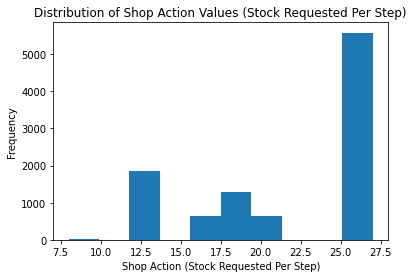

In [72]:
# Plot distribution of shop action (stock request) per step for all rollouts
plt.hist(shop_actions, bins=10)
plt.title("Distribution of Shop Action Values (Stock Requested Per Step)")
plt.xlabel("Shop Action (Stock Requested Per Step)")
plt.ylabel("Frequency")
plt.show()

Here we see that the stock held by shop is most commonly just over 25 units.

Depending on the variation in size of recent orders it may be less or more.

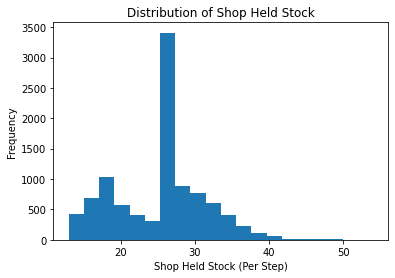

In [69]:
plt.hist(shop_stock, bins=20)
plt.title("Distribution of Shop Held Stock")
plt.xlabel("Shop Held Stock (Per Step)")
plt.ylabel("Frequency")
plt.show()

In the next plot we see that the average shop sales per step is just under the average of 25 orders placed per step.

In the second plot we see that as a result of this there is a small amount of steps in which the shop fails to fulfil all orders.

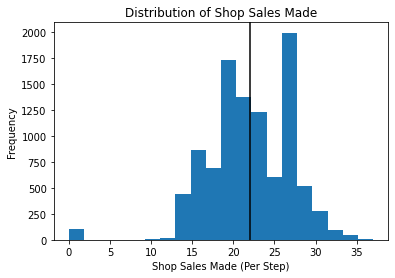

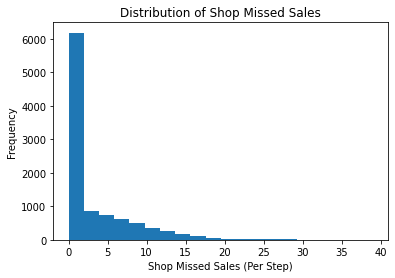

In [73]:
plt.hist(shop_sales, bins=20)
plt.axvline(np.mean(shop_sales), c="k")
plt.title("Distribution of Shop Sales Made")
plt.xlabel("Shop Sales Made (Per Step)")
plt.ylabel("Frequency")
plt.show()

plt.hist(shop_missed_sales, bins=20)
plt.title("Distribution of Shop Missed Sales")
plt.xlabel("Shop Missed Sales (Per Step)")
plt.ylabel("Frequency")
plt.show()